# Generate MAE reconstructions

In [1]:
import sys
import lightning as L
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

sys.path.append("..")

from models import MAEModule
from data import IBGE_Module
from utils import load_from_checkpoint, get_data_sample, time_series_to_rgb

/tatu/venv/ewab/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
CONFIG_FILE_PATH = "../configs/pretrain_config.yaml"

config = OmegaConf.load(CONFIG_FILE_PATH)
config

{'model': {'task': 'pretrain', 'backbone': 'mae', 'img_size': 96, 'num_channels': 10, 'num_frames': 2, 'patch_size': 8}, 'dataset': {'name': 'ibge', 'random_norms': True, 'validate': False, 'batch_size': 1024, 'num_workers': 4, 'data_dir': '/pgeoprj2/godeep/ewab/datasets/IBGE'}, 'solver': {'name': 'adam', 'criterion': 'dice', 'learning_rate': 0.0001, 'weight_decay': None, 'warmup_epochs': 40, 'max_epochs': 400, 'dev_run': False, 'overfit_batches': False}, 'checkpoint': {'save_dir': '/pgeoprj2/godeep/ewab/experiments/mae_pretrain', 'run_name': 'mae_random_norms', 'pretrain_weights': None, 'ckpt_path': '/pgeoprj2/godeep/ewab/experiments/mae_pretrain/wandb/ckpt_mae_random_norms/mae_random_norms-epoch=383-train_loss=0.00.ckpt', 'save_checkpoint': True}}

In [3]:
model_name = MAEModule

model = model_name(config)
model = load_from_checkpoint(config, model, model_name=model_name)

In [4]:
SAMPLE_INDICES = [0, 5, 20, 35, 40]

data_module = IBGE_Module(config)
data_module.setup()
subset_loader = get_data_sample(data_module.test_dataset, indices=SAMPLE_INDICES)

In [5]:
trainer = L.Trainer()
trainer.test(model, dataloaders=subset_loader)
outputs = trainer.predict(model, dataloaders=subset_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-11-11 12:14:24.555580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.1426333636045456     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

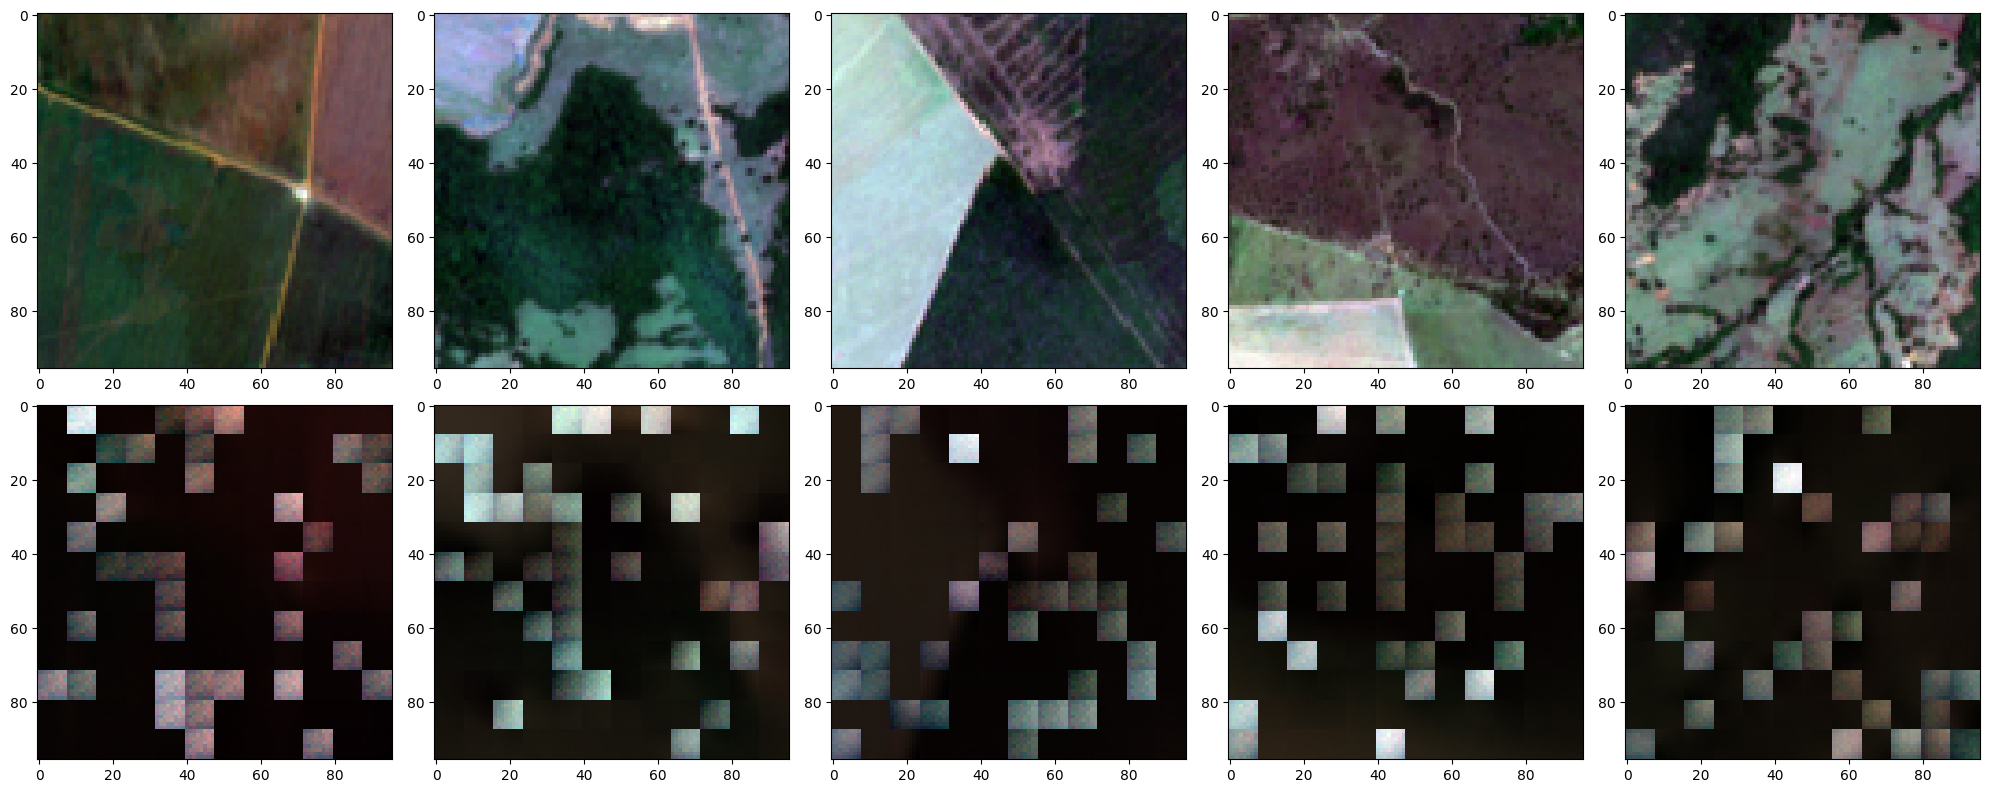

In [6]:
TIMESTAMP = 1

batch = outputs[0]
inputs, preds = batch["inputs"], batch["preds"]
fig, axes = plt.subplots(nrows=2, ncols=len(SAMPLE_INDICES), figsize=(20, 8))

for i, (image, pred) in enumerate(zip(inputs, preds)):
    image = time_series_to_rgb(image)
    pred = time_series_to_rgb(pred)

    axes[0, i].imshow(image[TIMESTAMP]) # Plot image
    axes[1, i].imshow(pred[TIMESTAMP]) # Plot reconstruction

plt.tight_layout()
plt.show()